# Sensitivity Tests Output

Working with the output from HiPerGator/main.py

In [206]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

import photoeccentric as ph

In [207]:
trueew = pd.read_csv('/Users/ssagear/Dropbox (UFL)/Research/MetallicityProject/photoeccentric/notebooks/plots_hpg/results/fnames.txt', index_col=False)

In [208]:
truee = np.array(trueew['true_e'])
truew = np.array(trueew['true_w'])

In [209]:
distpath = "/Users/ssagear/Dropbox (UFL)/Research/MetallicityProject/photoeccentric/notebooks/plots_hpg/results/edists/"
zscpath = "/Users/ssagear/Dropbox (UFL)/Research/MetallicityProject/photoeccentric/notebooks/plots_hpg/results/zscores/"

edist = []
zsc = []

for file in os.listdir(distpath):
    fname = os.path.join(distpath, file)
    try:
        edist.append(np.genfromtxt(fname, delimiter=','))
    except UnicodeDecodeError:
        pass
    

for file in os.listdir(zscpath):
    fname = os.path.join(zscpath, file)
    try:
        zsc.append(np.genfromtxt(fname, delimiter=','))
    except UnicodeDecodeError:
        pass

<ipython-input-209-fbe0739ad145>:10: UserWarning: genfromtxt: Empty input file: "/Users/ssagear/Dropbox (UFL)/Research/MetallicityProject/photoeccentric/notebooks/plots_hpg/results/edists/e_0.7016680685355956_w_-59.26857908763873_distributions.csv"
  edist.append(np.genfromtxt(fname, delimiter=','))


In [210]:
es = []
ws = []
gs = []

zsc_e = []
zsc_w = []

for i in range(len(edist)):
    try:
        es.append(edist[i][:,0])
        ws.append(edist[i][:,1])
        gs.append(edist[i][:,2])
    except IndexError:
        truee = np.delete(truee, i)
        truew = np.delete(truew, i)
    
    
for i in range(len(edist)):
    try:
        zsc_e.append(zsc[i][0])
        zsc_w.append(zsc[i][1])
    except IndexError:
        pass

In [212]:
es_mode = []
ws_mode = []
gs_mode = []

for i in range(len(es)):
    es_mode.append(ph.mode(es[i]))
    ws_mode.append(ph.mode(ws[i]))
    gs_mode.append(ph.mode(gs[i]))
    

In [213]:
zsc_means = []

for i in range(len(zsc_e)):
    zsc_means.append(np.mean((zsc_e[i], zsc_w[i])))

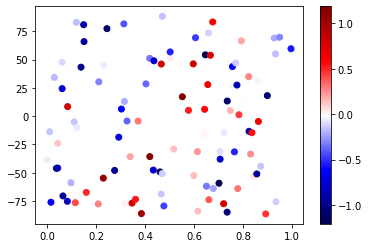

In [219]:
plt.scatter(truee, truew, c=zsc_means, cmap='seismic')
plt.colorbar()